$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Wind Speed Prediction Linear Regression Model

#### Melinda Ryan and David Thorpe

*Parts of this notebook are modified from homeworks and lecture material from the CS480 Machine Learning class.*

## Introduction

### Linear Regression
The linear model with $N$ samples, $\xv_n$ and target values $\tv_n$:
$$
\begin{align*}
   g(\xv;\wv) &= w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_D x_D \\
   &= w_0 + \sum_{i=1}^D w_i x_i \\
   & = \sum_{i=0}^D w_i x_i \mbox{, where } x_0 = 1 \\
   &= \wv^T \xv
\end{align*}
$$

The sum of squared error objective or distance from the target values:
$$
\begin{align*}
\sum_{n=1}^N (t_n - g(\xv_n;\wv))^2
\end{align*}
$$

We want to find the parameters $\wv = (w_0, w_1)$, to minimize the distance.
$$
    \wv_{\mbox{best}} = \argmin{\wv} \sum_{n=1}^N (t_n - g(x_n ; \wv))^2
$$

We can take the derivative, set it equal to 0 and solve for $\wv$. 

$$
\begin{align*}
\frac{\partial \sum_{n=1}^N (\tv_n - g(\xv_n;\wv))^2}{\partial \wv} &= -2 \sum_{n=1}^N (\tv_n - g(\xv_n;\wv) \frac{\partial g(\xv_n;\wv)}{\partial \wv}\\
&= -2 \sum_{n=1}^N (\tv_n - \xv_n^T \wv) \frac{\partial \xv_n^T \wv}{\partial \wv}\\
&= -2 \sum_{n=1}^N (\tv_n - \xv_n^T \wv) \xv_n^T
\end{align*}
$$

Translated to matrices and then set to zero and solve for $\wv$.

$$
\begin{align*}
-2 \Xv^T (\Tv - \Xv \wv) &= 0\\
\Xv^T (\Tv - \Xv \wv) &= 0\\
\Xv^T \Tv &= \Xv^T \Xv \wv\\
\wv &= (\Xv^T \Xv)^{-1} \Xv^T \Tv
\end{align*}
$$

### Linear Regression with Fixed Nonlinear Features
The models created are linear in the weights $\wv$
and linear in the features of the samples.  We can also make
models that are nonlinear in the attributes by adding nonlinear
functions of the original features.  

For a single feature, the data matrix is
$$
\begin{alignat*}{1}
 X &= \begin{bmatrix}
       x_0\\
       x_1\\
       \vdots \\
       x_N
       \end{bmatrix}
\end{alignat*}
$$
Adding powers of each $x$ value our matrix becomes
$$
\begin{alignat*}{1}
 X &= \begin{bmatrix}
       x_0 & x_0^2 & x_0^3 & x_0^4\\
       x_1 & x_1^2 & x_1^3 & x_1^4\\
       \vdots \\
       x_N & x_N^2 & x_N^3 & x_N^4\\
       \end{bmatrix}
\end{alignat*}
$$

In [51]:
import numpy as np
import mpl_toolkits.basemap as bm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import datetime as dt 
%matplotlib inline

### Multiple Linear Regression Functions

In [2]:
# The train function generates the weights based on the feature matrix and target vector. It returns a dictionary.
def train(X,T):
    means = np.mean(X,axis=0)
    stds = np.std(X,axis=0)
    Xs = standardize(X-means,stds)
    Xs1 = np.hstack((np.ones((Xs.shape[0],1)), Xs)) # The bias is a column of ones.                
    w = np.linalg.lstsq( np.dot(Xs1.T,Xs1), np.dot(Xs1.T, T) )[0]
    return {'means': means, 'stds': stds, 'w': w}

In [3]:
# Standardize function to account for divide by zero.
def standardize(a,b):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.divide( a, b )
        c[ ~ np.isfinite( c )] = 0  # -inf inf NaN
    return c

In [4]:
def use(X,model):
    #Standardize data
    Xs = standardize(X-model['means'],model['stds'])
    #bias 
    Xs1 = np.hstack((np.ones((Xs.shape[0],1)), Xs)) 
    prediction = np.dot(Xs1,model['w']) 
    return prediction

In [5]:
def rmse(predict,T):
    return np.sqrt(np.mean((predict - T)**2,axis=0))

In [6]:
def trainUsePlot(X,T,plotTitle):
    model = train(X,T)
    prediction = use(X,model)
    error = rmse(prediction,T)
    
    plt.plot(prediction,T,'o')
    plt.title(plotTitle)
    plt.xlabel('Predicted WindSpeed')
    plt.ylabel('Actual WindSpeed')
    # add a 45 degree line
    a = max(min(prediction),min(T))
    b = min(max(prediction),max(T))
    plt.plot([a,b],[a,b], 'r', linewidth=3,alpha=0.5);
    
    print("RMSE: ", error)

In [7]:
# Trains the model over the number of folds with each of the powers. Finds the power with the lowest RMSE.
def findBestPower(X,T,nFolds,maxPowers):
    results = []
    for Xtrain,Ttrain,Xtest,Ttest,_ in partitionKFolds(X,T,nFolds):
        for power in maxPowers:
            Xtrain2 = makeFeatures(Xtrain,power)
            Xtest2 = makeFeatures(Xtest,power)
            model = train(Xtrain2,Ttrain)
            trainError = rmse(use(Xtrain2,model),Ttrain),
            testError = rmse(use(Xtest2,model),Ttest)
            results.append([power,rmse(use(Xtrain2,model),Ttrain),rmse(use(Xtest2,model),Ttest)])
    results = np.array(results)
    realResults = meansAfterGroupedByFirstColumn(results)
    index = np.argmin(realResults[:,2])
    maxPow = realResults[index,0]
    return int(maxPow), realResults

In [8]:
# Code modified from the CS480 Machine Learning class. Divides the data into the number of folds specified.
def partitionKFolds(X,T,nFolds):
    '''Usage: for Xtrain,Ttrain,Xval,Tval,Xtest,Ttext in partitionKFolds(X,T,5):'''
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    for testFold in range(nFolds):
        # trainFolds are all remaining folds, after selecting test and validate folds
        trainFolds = np.setdiff1d(range(nFolds), [testFold])
        # Construct Xtrain and Ttrain by collecting rows for all trainFolds
        rows = []
        for tf in trainFolds:
            a,b = startsStops[tf]                
            rows += rowIndices[a:b].tolist()
        Xtrain = X[rows,:]
        Ttrain = T[rows,:]
        # Construct Xtest and Ttest
        a,b = startsStops[testFold]
        rows = rowIndices[a:b]
        Xtest = X[rows,:]
        Ttest = T[rows,:]
        # Return partition matrices, then suspend until called again.
        yield Xtrain,Ttrain,Xtest,Ttest,testFold

In [9]:
# Code used from CS480 Machine Learning class. 
# Collapses a matrix of results by calculating means of rows grouped by the value in the first column, maxPower.
def meansAfterGroupedByFirstColumn(data):
    result = []
    uniqs = np.unique(data[:,0])
    for x in uniqs:
        forx = data[data[:,0] == x, 1:]
        result.append([x] + np.mean(forx,0).tolist())
    return np.array(result)

In [10]:
# Creates the matrix of nonlinear features with the specified power.
def makeFeatures(X,maxPower):
    X1 = X
    for i in range(maxPower - 1):
        n = i+2
        X2 = X**n
        X1 = np.concatenate((X1,X2),axis=1)
    return X1

In [58]:
# Runs the findBestPower function to find the best power and plots the results.
def nonlinearfeatures(X,T,powers,folds,title):
    maxPow,avgs = findBestPower(X,T,folds,powers)
    print('Max Power: ',maxPow)
    print('Matrix: \n',avgs)
    
    plt.plot(powers,avgs[:,1], label='Train Error')
    plt.plot(powers,avgs[:,2], label='Test Error')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Error')
    plt.xlabel('Power')
    plt.title('Training Error and Testing Error for Each Power')

In [53]:
# Converts the date format 'YYYYMMDD' to a datetime object. Useful for plotting.
def convertToDate(val):
    val=val.astype(np.int64)
    date=np.array_str(val)
    date = time.strptime(date, "%Y%m%d") 
    date=dt.datetime(*date[:6])
    return date

In [59]:
# Creates plots of wind speed vs time. The format for time is expected to be 'YYYYMMDD'
def plotWindSpeedVsTime(times,winddata,title):
    dates = []
    for i in times:
        dates.append(convertToDate(i))
    datestoplot = matplotlib.dates.date2num(dates)
    
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.plot(datestoplot,winddata,'o')
    #plt.plot(20090630,1,'ro')
    axes = plt.gca()

    plt.xlabel('Time')
    plt.ylabel('Actual WindSpeed')

In [60]:
# Creates a map that shows the location of the stations specified by latitudes and longitudes.
def plotMaps(lats,lons,title):
    plt.figure(figsize=(15,30))
    plt.title(title)
    m = bm.Basemap(projection='merc', lat_0=36.5, lon_0=-96.5, 
                  resolution = 'h', area_thresh = 0.1, llcrnrlon=-126.0, llcrnrlat=20.0, urcrnrlon=-67.0, urcrnrlat=50.0)
    m.shadedrelief()
    m.drawcoastlines()
    m.drawcountries(linewidth=1.5, linestyle='solid', color='k')
    m.drawstates(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
    m.drawmapboundary()
    m.drawmeridians(np.arange(-126,-67,5.9))
    m.drawparallels(np.arange(25,48,2.3))

    x,y = m(lons, lats)
    m.plot(x,y, 'ro', markersize=8,alpha=0.1)
    plt.show()

## Make the Wind Data

In [15]:
# Our data has 13 features.
names=['yearmoda','temp','dewp','slp','stp', 'visib','max','min','prcp','sndp','lat','lon','elev']

In [16]:
# The output file from the MapReduce program has all the US data from 2009.
griddata = np.loadtxt('part-r-00000-1')

In [17]:
# There are 13 features and 263,548 samples.
Xtest = griddata[:,5:19]
Xtest.shape

(263548, 13)

In [18]:
# The target vector contains the wind speeds.
Ttest=griddata[:,2:3]
Ttest.shape

(263548, 1)

In [19]:
Alllats = griddata[:,15]/1000
Alllons = griddata[:,16]/1000

In [20]:
# Southern Rocky Mountain region is columns 2 and 3 in the grid.
colSelection = np.logical_or(griddata[:,1]==2, griddata[:,1]==3)
rockies=griddata[colSelection,:]
# Southern Rocky Mountain region are rows 3,4,5,6.
rowSelection = np.logical_or(np.logical_or(rockies[:,0]==3, rockies[:,0]==4), 
                             np.logical_or(rockies[:,0]==5, rockies[:,0]==6))
rockies=rockies[rowSelection,:]

# Lats and lons in thousandths.
Rlats = rockies[:,15]/1000
Rlons = rockies[:,16]/1000

In [21]:
# South Central region are columns 4 and 5 in the grid also the section 3,2 is in this region.
colSCentral = np.logical_or(np.logical_or(griddata[:,1]==4, np.logical_and(griddata[:,1]==5,griddata[:,0]!=7)),
                         np.logical_and(griddata[:,1]==3,griddata[:,0]==2))
SCentral=griddata[colSCentral,:]
# Rockies region are rows 3,4,5,6.
rowSCentral = np.logical_or(np.logical_or(np.logical_or(SCentral[:,0]==0,SCentral[:,0]==1), 
                                       np.logical_or(SCentral[:,0]==2,SCentral[:,0]==3)),
                         np.logical_or(np.logical_or(SCentral[:,0]==4,SCentral[:,0]==5),
                                       np.logical_or(SCentral[:,0]==6,SCentral[:,0]==7)))
SCentral=SCentral[rowSCentral,:]

# Lats and lons in thousandths.
SClats = SCentral[:,15]/1000
SClons = SCentral[:,16]/1000

In [22]:
# North Central region are columns 4 and 5 in the grid.
colNCentral = np.logical_or(griddata[:,1]==4, griddata[:,1]==5,)
NCentral=griddata[colNCentral,:]
# Rockies region are rows 7,8,9.
rowNCentral = np.logical_or(np.logical_or(NCentral[:,0]==7,NCentral[:,0]==8), NCentral[:,0]==9)
NCentral=NCentral[rowNCentral,:]

# Lats and lons in thousandths
NClats = NCentral[:,15]/1000
NClons = NCentral[:,16]/1000

Defining the feature matrices and target vectors for each region.

In [23]:
ncentralX=NCentral[:,5:19]
ncentralT=NCentral[:,2:3]

In [24]:
rockiesX=rockies[:,5:19]
rockiesT=rockies[:,2:3]

In [25]:
scentralX=SCentral[:,5:19]
scentralT=SCentral[:,2:3]

## Weather Stations Reporting

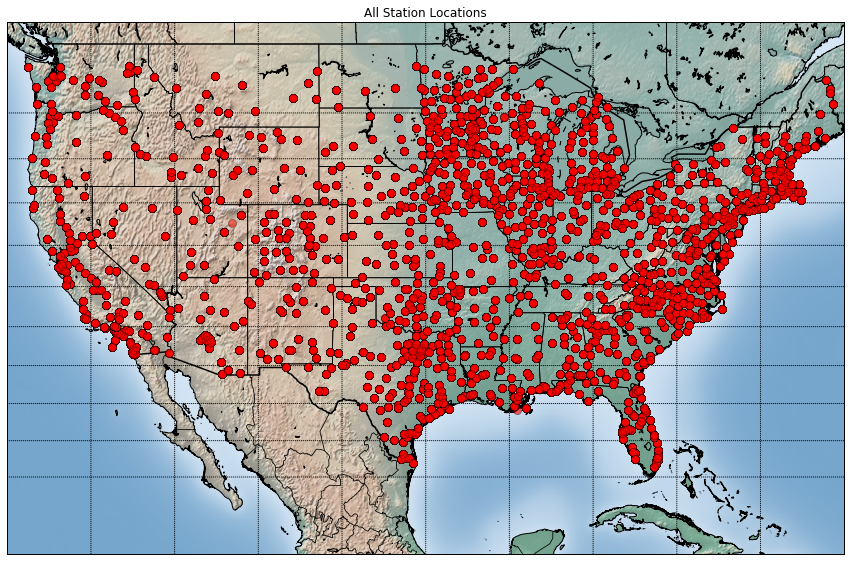

In [61]:
plotMaps(Alllats,Alllons,'All Station Locations')

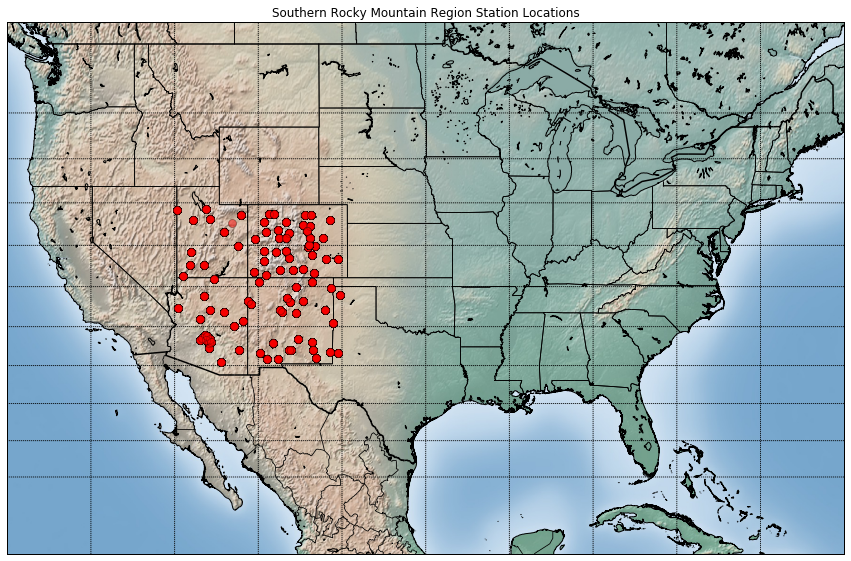

In [27]:
plotMaps(Rlats,Rlons,'Southern Rocky Mountain Region Station Locations')

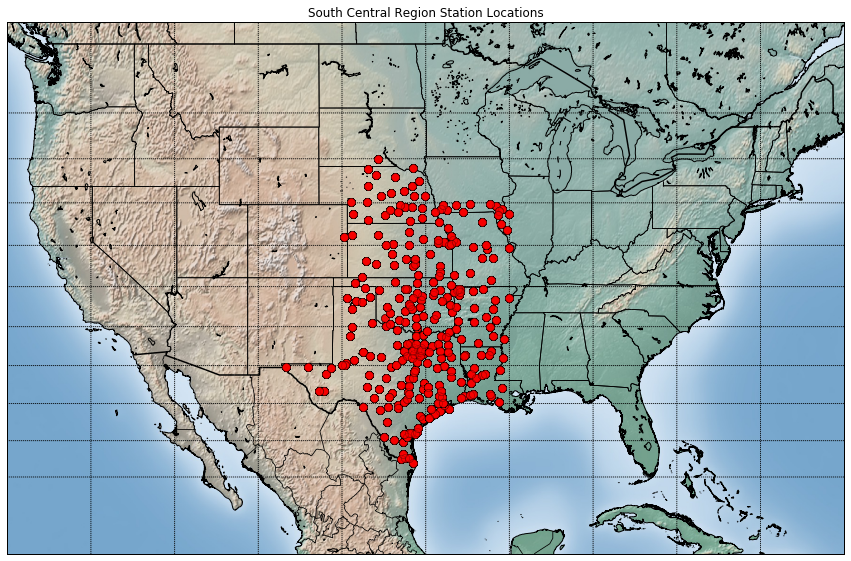

In [28]:
plotMaps(SClats,SClons,'South Central Region Station Locations')

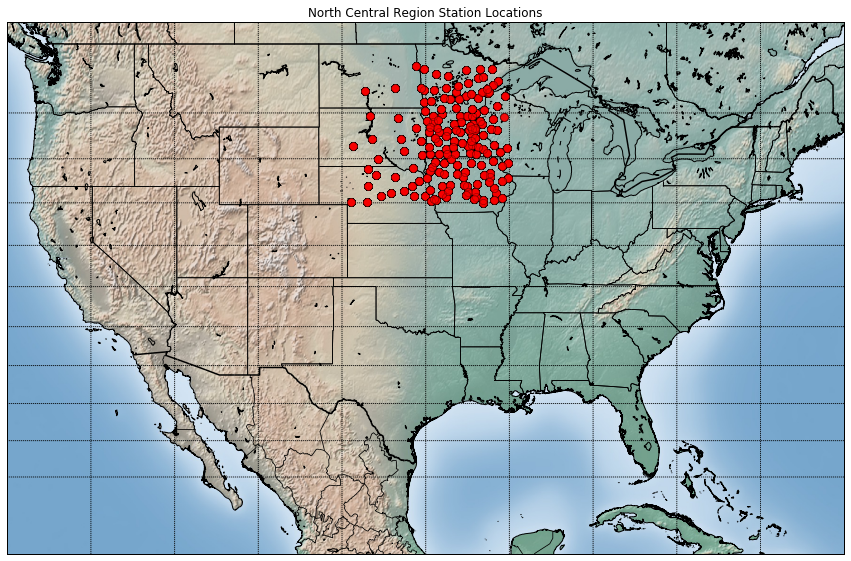

In [29]:
plotMaps(NClats,NClons,'North Central Region Station Locations')

## Attribute Plots

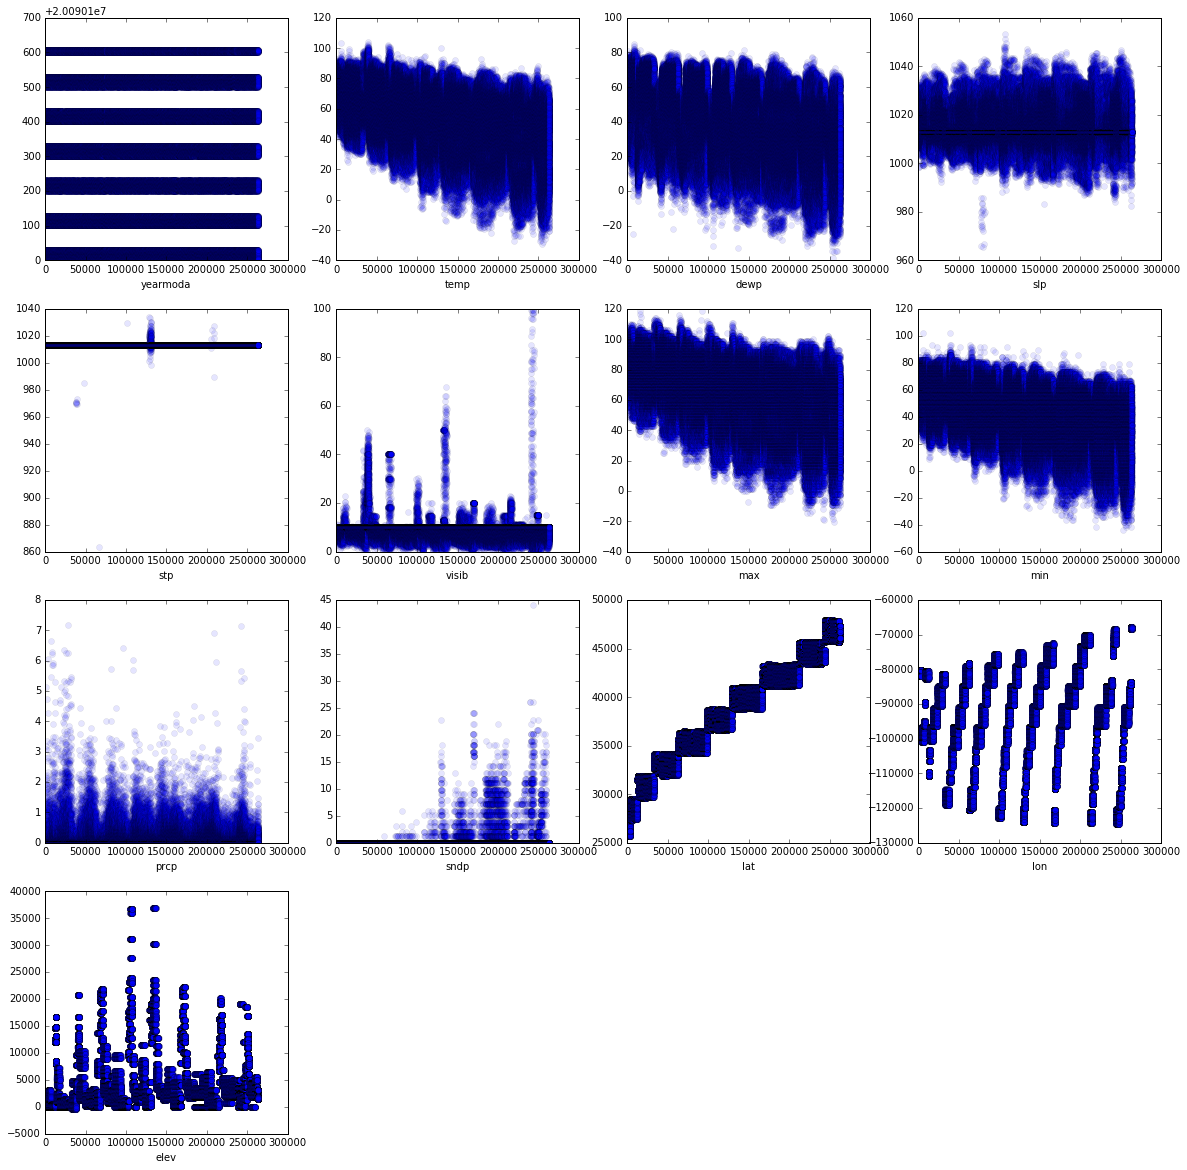

In [30]:
plt.figure(figsize=(20,20))
row,col = Xtest.shape
for i in range(col):
    plt.subplot(4,4, i+1)
    plt.plot(Xtest[:,i],'o',alpha=0.1)
    plt.xlabel(names[i])

The wind speeds plot shows the range of wind speed values.

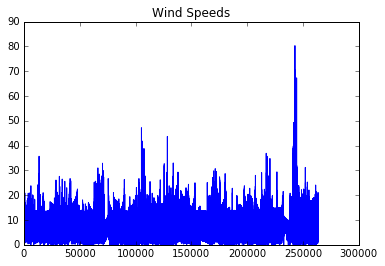

In [31]:
plt.title('Wind Speeds')
plt.plot(Ttest)

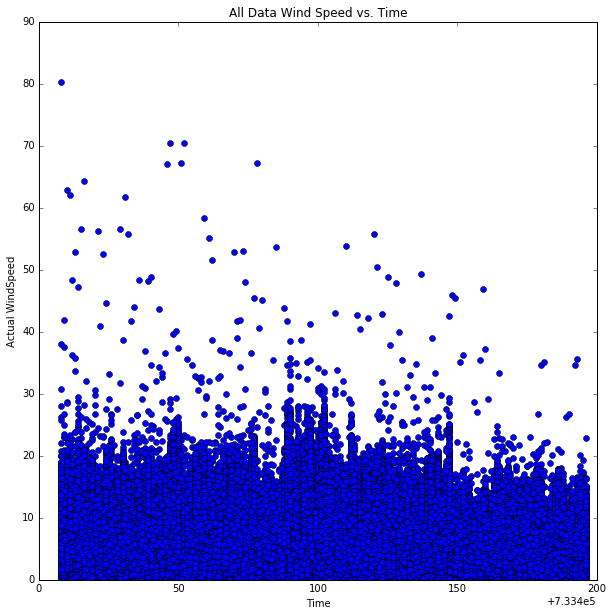

In [32]:
plotWindSpeedVsTime(griddata[:,5],griddata[:,2:3],'All Data Wind Speed vs. Time')

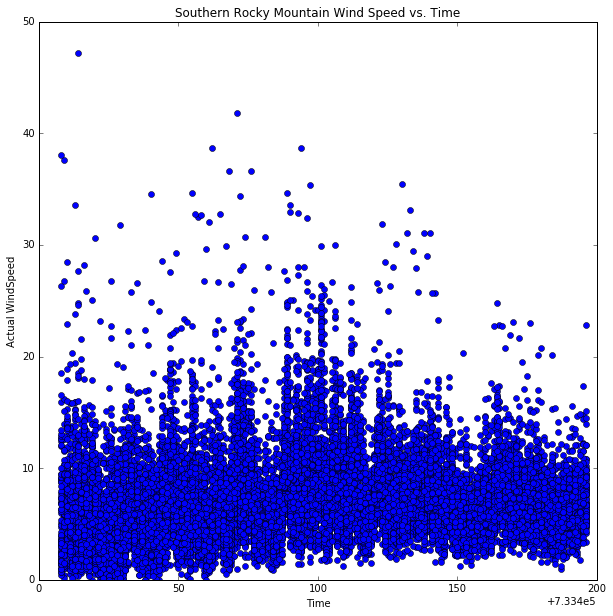

In [33]:
plotWindSpeedVsTime(rockies[:,5],rockies[:,2:3],'Southern Rocky Mountain Wind Speed vs. Time')

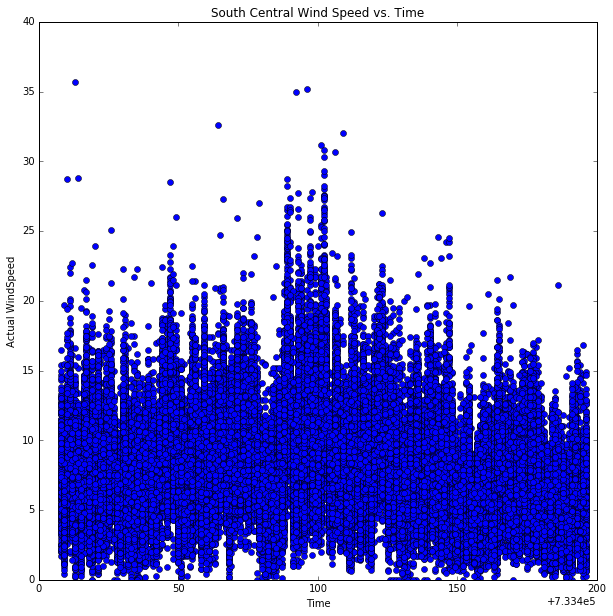

In [34]:
plotWindSpeedVsTime(SCentral[:,5],SCentral[:,2:3],'South Central Wind Speed vs. Time')

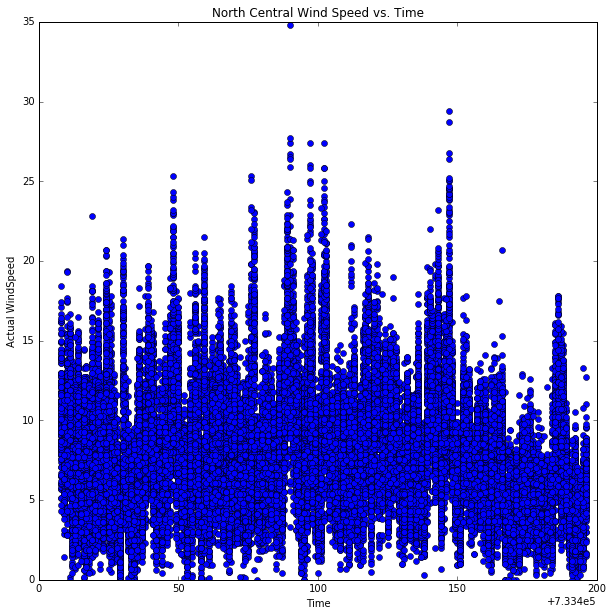

In [35]:
plotWindSpeedVsTime(NCentral[:,5],NCentral[:,2:3],'North Central Wind Speed vs. Time')

## Creating Models

Using all the data, we created a multiple linear regression model without k-fold validation to test the functions. 

In [36]:
testModel = train(Xtest,Ttest)
testPrediction = use(Xtest,testModel)

In [37]:
error = rmse(testPrediction,Ttest)
error

array([ 3.57683687])

In [38]:
# The weights of each feature determined by this model.
w = testModel['w']
for wi,name in zip(w.flat,names):
    print('{:8.3f}  {:s}'.format(wi,name))

   6.811  yearmoda
  -0.654  temp
  -2.527  dewp
  -1.836  slp
  -0.695  stp
  -0.016  visib
   0.229  max
  -0.030  min
   4.436  prcp
   0.173  sndp
   0.227  lat
   0.133  lon
   0.006  elev


RMSE:  [ 3.57683687]


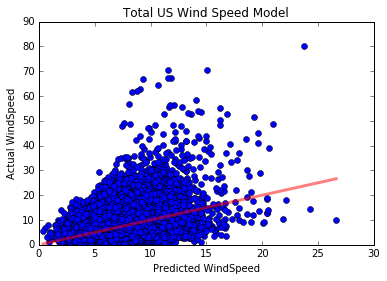

In [39]:
trainUsePlot(Xtest,Ttest,'Total US Wind Speed Model')

We then created a linear model on all the data with fixed nonlinear features. The nonlinear features are powers of X. Here, X raised to the third power appears to give the lowest RMSE with 10 folds.

Max Power:  3
Matrix: 
 [[ 1.          3.57345739  3.64050425]
 [ 2.          3.41660882  3.59706944]
 [ 3.          3.34846152  3.45588242]
 [ 4.          3.45926473  3.97008997]
 [ 5.          3.27658863  4.35824907]]


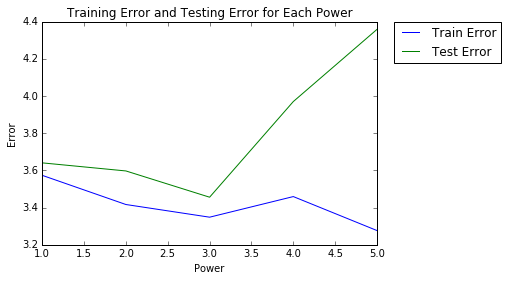

In [40]:
# nonlinearfeatures function requires the feature matrix, target vector, range of powers to try, and the number of folds.
powers = range(1,6)
nonlinearfeatures(Xtest,Ttest,powers,10)

We created models for each of the region subsets without k-folds. 

RMSE:  [ 3.46752575]


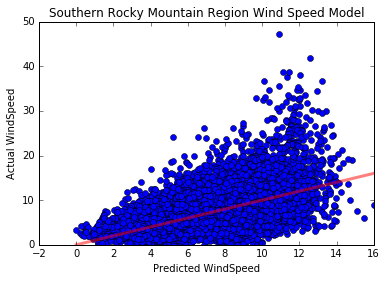

In [41]:
trainUsePlot(rockiesX,rockiesT,'Southern Rocky Mountain Region Wind Speed Model')

RMSE:  [ 3.49942534]


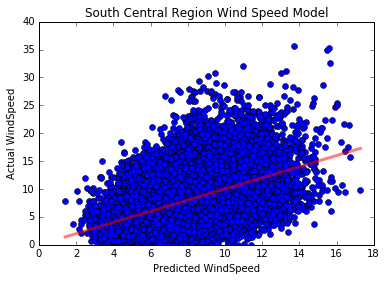

In [42]:
trainUsePlot(scentralX,scentralT,'South Central Region Wind Speed Model')

RMSE:  [ 3.65569297]


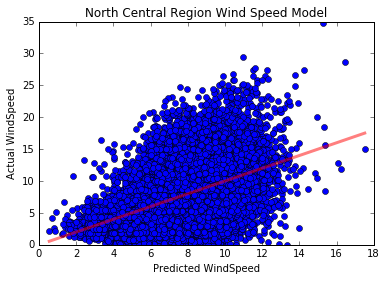

In [43]:
trainUsePlot(ncentralX,ncentralT,'North Central Region Wind Speed Model')

We then created the models using k-folds cross validation and added in nonlinear features. 

Max Power:  3
Matrix: 
 [[ 1.          3.46360209  3.48507826]
 [ 2.          3.23054283  3.30805297]
 [ 3.          3.10996382  3.21901552]]


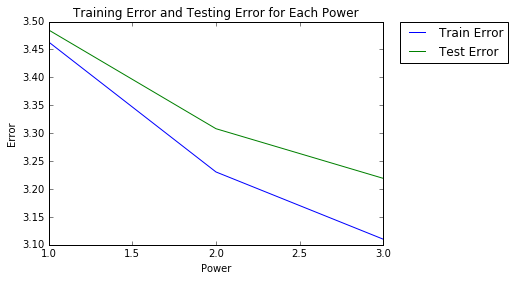

In [44]:
powers = range(1,4)
nonlinearfeatures(rockiesX,rockiesT,powers,10)

Max Power:  2
Matrix: 
 [[ 1.          3.49505147  3.5711824 ]
 [ 2.          3.30254492  3.507716  ]
 [ 3.          3.23069516  3.52966272]]


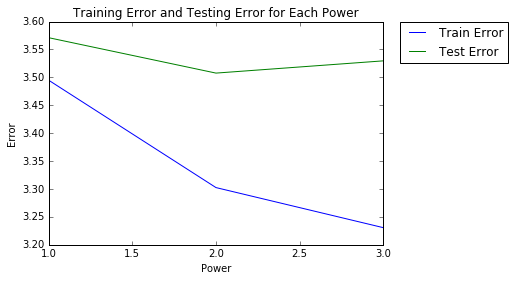

In [45]:
powers = range(1,4)
nonlinearfeatures(scentralX,scentralT,powers,10)

Max Power:  2
Matrix: 
 [[ 1.          3.65289044  3.69309173]
 [ 2.          3.50580489  3.54205996]
 [ 3.          3.46784157  3.60144083]
 [ 4.          3.44752248  3.99361368]
 [ 5.          3.43947296  4.61997888]]


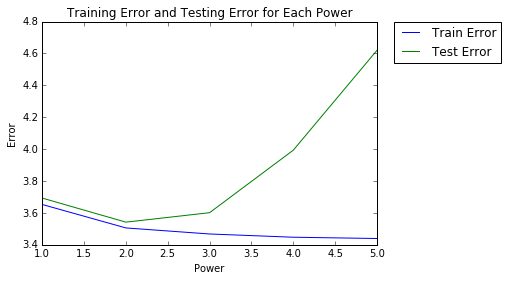

In [46]:
powers = range(1,6)
nonlinearfeatures(ncentralX,ncentralT,powers,10)